<a id="top"></a> 
# The Power Spectrum (Part 2)

<div class="question">
    
_**Synopsis**_ 

**Data:** Field data: 1 s of ECoG data sampled at 500 Hz.

**Goal:** Characterize the observed rhythms in these data.

**Tools:** Fourier transform, power spectral density, spectrogram.

</div>

* [Introduction](#.)
* [Data analysis](#data-analysis)
    1. [Visual inspection](#visual-inspection)
    2. [Spectral Analysis: The Rectangular Taper and Zero Padding](#rect-tapers)
    3. [Beyond the Rectangular Taper—the Hanning Taper](#hann-taper)
    4. [Beyond the Hanning Taper—the Multitaper Method](#multitaper)
    5. [Confidence Intervals of the Spectrum](#ci)
* [Summary](#summary)
* [Donate](#donate)
* [Appendix: Multiplication and Convolution in Different Domains](#appendix)

## On-ramp: computing the tapered spectrum in Python
We begin this notebook with an "*on-ramp*" to analysis. The purpose of this on-ramp is to introduce you immediately to a core concept in this notebook: how to compute the power spectrum with a taper in Python. You may not understand all aspects of the program here, but that's not the point. Instead, the purpose of this on-ramp is to illustrate what *can* be done. Our advice is to simply run the code below and see what happens ...

In [60]:
# Prepare the standard modules
from pylab import *
import scipy.io as sio
%matplotlib inline
rcParams['figure.figsize']=(8,2.5)  # Change the default figure size

In [61]:
# Import the tools for the notebook
import nitime.algorithms.spectral as spectrum
from scipy.stats import chi2

x shape:  (500,)
dt = 0.002 N = 500 T = 1.0


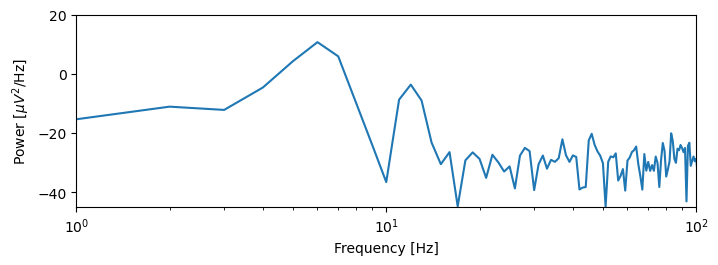

In [94]:
data = sio.loadmat('matfiles/04_ECoG-1.mat')    # Load the ECoG data.
x    = data['ECoG'].reshape(-1)          # Extract the ECoG variable,
print("x shape: ",x.shape)
t    = data['t'][0]                      # ... and the t variable

dt = t[1] - t[0]                         # Define the sampling interval.
N = x.shape[0]                           # Define the total number of data points.
T = N * dt                               # Define the total duration of the data.
print('dt =', dt, 'N =', N, 'T =', T)     # Print the values.
x  = hanning(N) * x                      # Apply the Hanning taper to the data.
xf = fft(x - x.mean())                   # Compute Fourier transform of x.
Sxx = 2 * dt ** 2 / T * (xf * conj(xf))  # Compute the spectrum,
Sxx = real(Sxx[:int(len(x) / 2)])        # ... and ignore negative frequencies.

df = 1 / T.max()                         # Determine the frequency resolution.
fNQ = 1 / dt / 2                         # Determine the Nyquist frequency.
faxis = arange(0,fNQ,df)                 # Construct a frequency axis.

semilogx(faxis[1:],10*log10(Sxx[1:]), label="with taper")    # Plot spectrum vs frequency,
xlim([faxis[1], 100])                    # Select frequency range,
ylim([-45, 20])                          # ... and the power range.
xlabel('Frequency [Hz]')                 # Label the axes
ylabel('Power [$\mu V^2$/Hz]')
show()

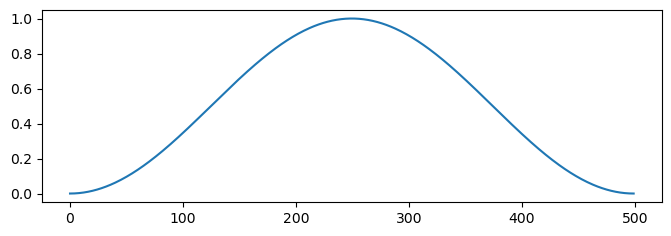

In [63]:
plot(hanning(N));

<div class="question">
    
**Q:** Try to read the code above. Can you see how it loads data, applies a taper, computes the spectrum, and then plots the results?

**A:** If you've never tapered your data and computed a spectrum before, that's an especially difficult question. Please continue on to learn this **and more**!

</div>

## Introduction
In <a href="03" rel="local">The Power Spectrum (part 1)</a>, we considered noninvasive recordings of brain electrical activity using scalp EEG. Although the scalp EEG provides fine temporal resolution of brain activity, the spatial resolution is poor because of the low conductivity of the skull [<a href="https://doi.org/10.1093/acprof:oso/9780195050387.001.0001" rel="external">Nunez & Srinivasan, 2005</a>]. An alternative, invasive approach to improve the spatial resolution of the scalp EEG is to record directly from the brain’s surface [<a href="https://doi.org/10.1038/nrn1585" rel="external">Engel, Moll, Fried, & Ojemann, 2005</a>]. This technique, known as electrocorticogram (ECoG), eliminates the distorting spatial blurring effect of the skull at the cost of an invasive surgical procedure of implantation.

### Case study data
A patient with epilepsy is scheduled to undergo resective surgery to remove the portion of her brain causing recurrent, unprovoked seizures. As part of her clinical workup, electrodes are implanted beneath the skull, directly on the brain’s surface. We assume that our skilled neurosurgeon collaborator expertly implants the ECoG electrode, and that the ECoG data are collected with no artifacts. We receive from our clinical collaborator a 1 s segment of ECoG data recorded from a single electrode and sampled at 500 Hz. 

### Goals
Our collaborator would like to know what rhythms appear in these invasive brain voltage recordings. Our goal is to analyze the 1 s of ECoG data by characterizing the rhythmic attributes of the activity. To do so, we build upon the spectral analysis techniques developed in <a href="03" rel="local">The Power Spectrum (part 1)</a>.

### Tools
In this notebook, we continue to develop understanding of the Fourier transform and spectrum. We apply the techniques introduced in <a href="03" rel="local">The Power Spectrum (part 1)</a> to compute the spectrum. We also investigate the impact of windowing and zero padding on the spectrum, and explain how to apply and interpret the multitaper method.

<a id="data-analysis"></a>
## Data analysis

As always, we begin by looking at the data. Let's load the ECoG data into Python and plot it by issuing the following commands:

(500, 1) (1, 500)


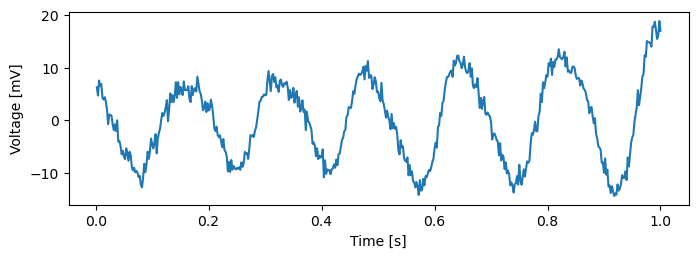

In [64]:
data = sio.loadmat('matfiles/04_ECoG-1.mat')  # Load the ECoG data
print(data['ECoG'].shape, data['t'].shape)
ecog = data['ECoG'].reshape(-1)   # Extract the ECoG variable
t = data['t'][0]                  # ... and the t variable

plot(t, ecog)                     # Plot the data versus time
xlabel('Time [s]')                # Label the time axis
ylabel('Voltage [mV]')            # ... and the voltage axis
# savefig('imgs/4-1')
show()

You might notice a dominant rhythmic activity. We can approximate the frequency of this rhythm by counting the number of oscillations that occur in the 1 s interval. To do so, let's approximate the total number of large-amplitude cycles that we observe in the data. Through visual inspection, we find that the first large-amplitude cycle occurs between $\approx$ 0 s and $\approx$ 0.175 s, the next between $\approx$ 0.175 s and $\approx$ 0.3 s, and so on. Counting this way, we approximate 6 full cycles per second, or a dominant 6 Hz rhythm.

<a id="rect-tapers"></a>
## Spectral Analysis: The Rectangular Taper and Zero Padding

Visual inspection, although essential to data analysis, is usually not enough. Visual inspection often guides intuition and reveals major features of the data, but it may also lead us astray; initial looks can be deceiving. To further explore the rhythmic activity of the ECoG data, we compute the spectrum.<sup><abbr title="We could instead write the sample spectrum because we use the observed data to estimate the theoretical spectrum that we would see if we kept repeating this experiment. However, this distinction is not essential to the discussion here.">note</abbr></sup> We do so using the same approach implemented in <a href="03" rel="local">The Power Spectrum (part 1)</a>. The code is nearly the same:
<a id="fig:4-2a"></a>

In [65]:
def get_spectrum(x, t):
    
    dt = t[2] - t[1]
    T = t[-1]
    xf = fft(x - x.mean()) 
    Sxx = real(2 * dt ** 2 / T * (xf * conj(xf)))
    df = 1.0 / T
    # fNQ = 1 / dt / 2
    faxis = arange(len(Sxx)) * df
    return faxis, Sxx

df = 1.0 fNQ = 250.0 dt = 0.002 T = 1.0


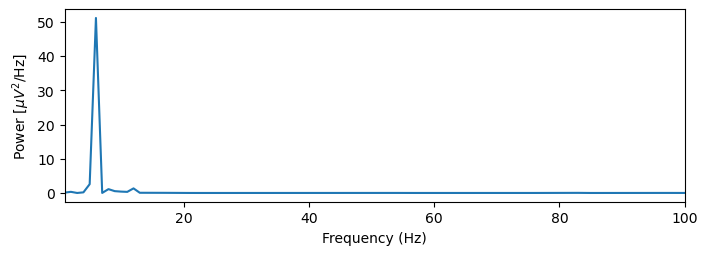

In [66]:
x = ecog          # Relabel the data variable
dt = t[2] - t[1]  # Define the sampling interval
T = t[-1]         # ... and duration of data

xf = rfft(x - x.mean())                        # Compute the Fourier transform of x,
Sxx = real(2 * dt ** 2 / T * (xf * conj(xf)))  # ... and the spectrum.

df = 1 / T                                     # Define the frequency resolution.
fNQ = 1 / dt / 2                               # Define the Nyquist frequency.
faxis = arange(len(Sxx)) * df                  # Construct the frequency axis.
plot(faxis, Sxx)                               # Plot spectrum vs. frequency,
xlim([1, 100])                                 # ... in select frequency range,
xlabel('Frequency (Hz)')                       # ... with axes labeled.
ylabel('Power [$\mu V^2$/Hz]')
# savefig('imgs/4-2a')
print('df =', df, 'fNQ =', fNQ, 'dt =', dt, 'T =', T)
show()

<div class="question">

**Q.** For the ECoG data considered here, what is the frequency resolution $df$, and what is the Nyquist frequency ($f_{NQ}$)? Compare your answers to the variables ``df`` and ``fNQ`` defined in the code. 

</div>

<div class="question">
    
**Q.** Interpret the spectrum of the ECoG data. What rhythms appear? 

</div>

The plot of the spectrum suggests a single dominant frequency near 6 Hz, consistent with the visual inspection of the [ECoG trace](#fig:4-1).<span class="sup">fig<img src="imgs/4-1.png"></span> Other interesting structure may also appear, perhaps at frequencies near 10 Hz; note the tiny peak barely visible in the spectrum. These initial observations suggest we can more appropriately scale the spectrum to emphasize both the low-frequency bands and weaker signals. Let’s utilize a logarithmic scale for both the power spectral density (decibels) and the frequency.

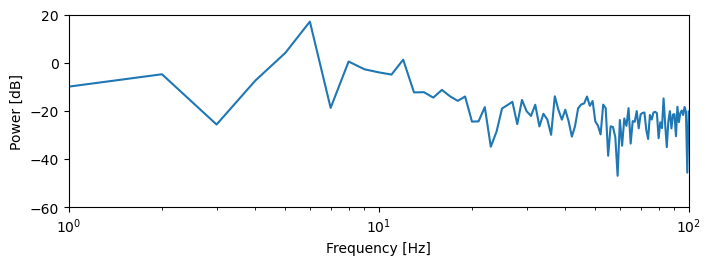

In [67]:
semilogx(faxis, 10 * log10(Sxx)) # Plot spectrum vs frequency,
xlim([1, 100])                      # ... in select frequency range,
ylim([-60, 20])                     # ... and power range,
xlabel('Frequency [Hz]')            # ... with axes labeled.
ylabel('Power [dB]')
# savefig('imgs/4-2b')
show()

<div class="question">
<p>
    
**Q.** Are the terms *frequency resolution*, *Nyquist frequency*, *Fourier transform*, *decibel*, and *spectrum* familiar? Can you define or explain each term?

</p>

<p>
    
**A.** If not, we recommend reviewing the case study in <a href="03" rel="local">The Power Spectrum (part 1)</a>.

</p>
</div>

#### By Doing Nothing, We're Doing Something: The Rectangular Taper.

ECoG time series continue for long durations. For example, an individual’s brain voltage activity may persist for over 90 years, from birth until death. However, ECoG recordings are finite, limited by convenience, technology, or other factors. In the example here, we consider 1 s of ECoG data. Performing this finite observation (lasting 1 s) on a long duration (i.e., 90-year) time series can be understood as a rectangular taper. A rectangular taper multiplies the observed data by 1 and the unobserved data by 0. 

<a id="fig:4-3"></a>
![Example of rectangular taper application.](imgs/4-3.png "Example of rectangular taper application. Raw data continue for a long period of time (top). Most of these data are unobserved. Rectangular taper (red) specifies the interval of observation. Multiplying the raw data by the rectangular taper determines the observed ECoG data (bottom).")

We can think of the value 1 as representing the time period when our recording device is operational; activating the ECoG recording device opens the rectangular taper (value 1), and deactivating the ECoG recording device closes the rectangular taper (value 0). The rectangular taper makes explicit our knowledge about the observed data (in this case, the 1 s interval of ECoG) and our ignorance about the unobserved data, which are assigned the value zero. Notice that the rectangular taper looks like a rectangle (red trace in the figure above).

So, by computing the spectrum of 1 s of observed ECoG data, we’re actually computing the spectrum of the product of two functions: the many years of mostly unobserved ECoG data and the rectangular taper. We note that by "doing nothing" we have implicitly made the choice to use the rectangular taper. We have already plotted the resulting spectrum of the observed ECoG data (again, using the default rectangular taper).<span class="sup">a, <img src="imgs/4-2a.png"></span><span class="sup">b<img src="imgs/4-2b.png"></span>

#### Exploring the Impact of the Rectangular Taper.
The figure<span class="sup">fig<img src="imgs/4-3.png"></span> above illustrates how the rectangular taper impacts the observed data in the time domain, namely, the taper selects a region of observation. The rectangular taper also impacts the spectrum in the frequency domain. To see this, consider a perfect sinusoid at frequency 10 Hz that in theory continues forever. In this case, the energy concentrates at a single frequency—the frequency of the sinusoid (10 Hz)—and for the (theoretical) case of an infinite sinusoid, the power spectral density is infinite at that frequency. <a id="fig:4-4"></a>
![Example of rectangular taper application to a sinusoid. (a) Infinite sinusoid continues forever in time; energy concentrates at sinusoid’s frequency of 10 Hz.](imgs/4-4a.png)

In mathematical language, we say that the spectrum of the infinite sinusoid is a *delta function*. However, we never observe an infinite sinusoid; to do so would require unlimited resources and unlimited time. Instead, let’s assume we observe only 1 s of the sinusoid’s activity; we imagine multiplying the infinite duration sinusoid by a rectangular taper and observing only a finite interval of time.
![Example of rectangular taper application to a sinusoid. (b) Multiplying the infinite duration sinusoid by a rectangular taper (red) yields a sinusoid of finite duration. Spectrum of the resulting signal (black) exhibits features at many frequencies, with peak at 10 Hz.](imgs/4-4b.png)

<div class="question">
    
**Q.** Examine the spectrum of the finite sinusoid (b)<span class="sup">fig<img src="imgs/4-4b.png"></span>. What do you see? Is the spectrum concentrated at one frequency (near 10 Hz), as we expected for an infinite sinusoid?
  
**A.** Visual inspection of the spectrum suggests an unexpected result: the spectrum is *not* concentrated at a single frequency. Instead, many peaks appear, centered at the expected frequency (10 Hz) but also spreading into neighboring frequency bands. The culprit responsible for this leakage outside of the 10 Hz peak is the rectangular taper applied to the true infinite-duration sinusoidal signal.

</div>

To understand further the impact of the rectangular taper, let’s consider the spectrum of the rectangular taper itself.

To compute the spectrum of the rectangular taper, we consider the following time series. 
<a id="fig:4-5a"></a>

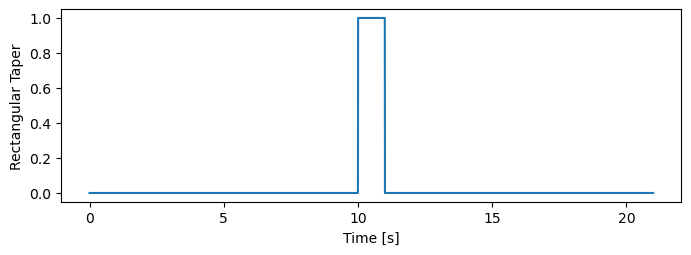

In [68]:
a = zeros(int(10/dt))      # Create 10 s of zeros,
b = ones(int(1/dt))        # ... and 1 s of ones,
taper = hstack((a,b,a))    # ... stack them together,
t = arange(len(taper))*dt  # ... define a time axis,            
plot(t, taper)             # ... and plot taper vs time.
xlabel('Time [s]')         # ... with axes labeled.
ylabel('Rectangular Taper')
# savefig('imgs/4-5a')
show()

In theory, the rectangular taper is infinite, and is preceded and followed by infinite intervals of zeros (i.e., there’s an infinite period in which we do not observe the ECoG data). To represent the infinite extent of the rectangular taper, we add 10 s of zeros to the beginning and end of a 1 s interval of ones. Of course, 10 s of zeros is a poor representation of an infinite interval of time, but it’s sufficient for our purposes here. We note that the rectangular taper consists of two sharp edges, when the observation interval opens and closes (i.e., transitions from 0 to 1, and then back from 1 to 0).

In [69]:
# faxis, Sxx = get_spectrum(taper, t)  # Compute the spectrum of the taper,
# Sxx[Sxx==0] = nan

# plot(faxis, 10 * log10(Sxx))                         # Plot the spectrum vs frequency,
# xlim([0, 5])                                         # ... in select range,
# ylim([-40, 10])
# xlabel('Frequency [Hz]')                             # ... with axes labeled.
# ylabel('Power [dB]')

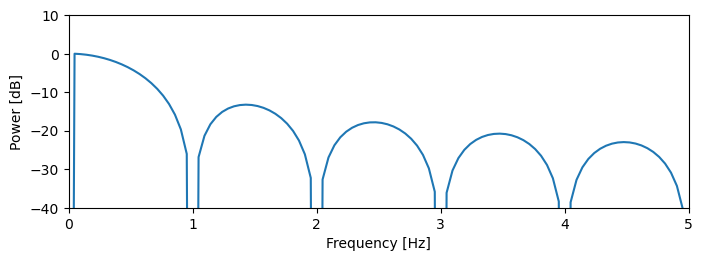

In [70]:
taperf = rfft(taper - taper.mean())                  # Compute Fourier transform of the taper,
Sxx = real( 2*dt**2/t.max() * (taperf*conj(taperf))) # ... and the spectrum,
Sxx = Sxx / Sxx.max()                                # ... scaled to have maximum of 0.

df = 1 /  t.max()                                    # Define the frequency resolution.
fNQ = 1 / dt / 2                                     # Define the Nyquist frequency.
faxis = arange(len(Sxx)) * df                        # Construct frequency axis.

Sxx[Sxx == 0] = nan                                  # Avoid division by 0 errors,
plot(faxis, 10 * log10(Sxx))                         # Plot the spectrum vs frequency,
xlim([0, 5])                                         # ... in select range,
ylim([-40, 10])
xlabel('Frequency [Hz]')                             # ... with axes labeled.
ylabel('Power [dB]')
show()

<div class="question">
    
**Q.** Examine the spectrum of the rectangular taper window. What do you see? At what frequency is the spectrum concentrated?

</div>

Visual inspection of the spectrum of the rectangular taper suggests that most of the power spectral density is concentrated at a single frequency, 0 Hz. To understand why the spectrum concentrates at 0 Hz, consider the [rectangular taper](#fig:4-5a)<span class="sup">fig<img src="imgs/4-5a.png"></span> over the 1 s duration for which the data collection window is open. Within this window, the value of the taper is the constant 1. The only frequency present in this signal is 0 Hz (i.e., no oscillations occur). Therefore, the spectrum is concentrated at 0 Hz.

Although the spectrum is concentrated at 0 Hz, it exhibits regions of increased spectral density at nonzero frequencies, more specifically, the repeated peaks (or side lobes) in the spectrum near 1.5 Hz, 2.5 Hz, 3.5 Hz, and so on. In fact, it's possible ot work out exactly the functional form of the Fourier transform of the rectangular taper; it's the sinc function [<a href="https://doi.org/10.1017/CBO9780511622762" rel="external">Percival & Walden, 1993</a>]. However, that's not particularly important for our purposes. The important result here is that the rectangular taper itself has a complicated spectrum, with features appearing across a range of frequencies.

<div class="question">
    
**Q.** Why does the spectrum of the rectangular taper contain features at many frequencies?
    
**A.** The spectrum consists of features at many frequencies to represent the rapid increase and decrease of the rectangular taper (i.e., the rapid transition from 0 to 1, and then from 1 to 0). The intuition for this is that many sinusoids, aligned in a particular way, are required to represent a sharp transition in a time series. As an example, consider the following square wave function: 

<a id="fig:4-6"></a>
![Approximation of a square wave with sinusoids.](imgs/4-6.png "Approximation of a square wave with sinusoids. Square wave (black) has a period of 2 Hz. As the number of sinusoids used to spproximate the square wave increases from (a) one sinusoid, to (b) two sinusoids, to (c) five sinusoids, approximation improves. Scale bar indicates 0.5 s.")
    
This square wave (black) consists of many repeated sharp transitions. Visual inspection suggests that the square wave is rhythmic, with a period of 2 Hz. Notice that the square wave begins at a sustained value of 1, then transitions to 0 and remains there for an interval of time, and then transitions back to a value of 1 in 0.5 s; the square wave therefore completes two cycles in 1 second.
 
So, the square wave is rhythmic, and we may try to represent this square wave with rhythmic sinusoids. In *(a)*, we plot a 2 Hz sinusoid. It’s an okay match to the square wave but certainly not perfect; the 2 Hz sinusoid fails to capture the sharp transitions of the square wave. In *(b)*, we plot the sum of a 2 Hz sinusoid and a 6 Hz sinusoid. The combination of these two sinusoids better matches the square wave, although again the sharp transitions are not accurately captured. In *(c)*, we plot the sum of 2 Hz, 6 Hz, 10 Hz, 14 Hz, and 18 Hz sinusoids. These five sinusoids better match the square wave and begin to more accurately capture the sharp transitions. As more sinusoids are used to represent the square wave, the approximation of the sharp edges improves.
   
So, sharp transitions in data require many sinusoids to be accurately approximated. The rectangular taper consists of sharp transitions and therefore requires sinusoids at many frequencies for an accurate representation.

</div>

Because we perform multiplication of two functions in the time domain (i.e., we multiply the rectangular taper and the infinite sinusoid element by element), we produce a convolution of the Fourier transforms of these functions in the frequency domain. Although the mathematical expression of convolution is somewhat complicated, we can understand the impact of convolution by examining a few plots. Let’s start with the Fourier transform of the infinite sinusoid and the infinite rectangular taper (where we’ve appended zeros to the rectangular taper to make it infinite). We know (or can look up) the results of each Fourier transform. The Fourier transform of the infinite 10 Hz sinusoid, which we assume here is a cosine function, consists of two delta functions at ±10 Hz. 

<a id="fig:4-7a"></a>
![A 10 Hz sinusoid and its Fourier transform.](imgs/4-7a.png "A 10 Hz sinusoid and its Fourier transform.")

The Fourier transform of the rectangular taper is the sinc function. 

<a id="fig:4-7b"></a>
![A rectangular taper and its Fourier transform.](imgs/4-7b.png "A rectangular taper and its Fourier transform.")

Now, let’s imagine shifting in frequency the Fourier transform of the rectangular taper (i.e., shifting in frequency the sinc function). At each shift, we multiply element by element the two Fourier transforms (i.e., the unshifted Fourier transform of the sinusoid and the shifted Fourier transform of the rectangular taper) and sum the product. The result of this shifting, multiplying, and summing of one Fourier transform by the other is the convolution.

<div class="question">
    
**Q.** What is the result of this convolution? How is the expected Fourier transform of the infinite sinusoid affected? 

</div>

To illustrate this convolution procedure, consider the following plots which show examples of shifting and multiplying the two Fourier transforms. 
<a id="fig:4-7cde"></a>
![Fourier transform of a function and its convolution at different shifts.](imgs/4-7cde.png "Illustration of the Fourier transform of each function (left) and their convolution evaluated at different shifts (right in green). Shifts up to 1 Hz (c), 5 Hz (d), and 15 Hz (e) are shown.")
The top plot shows the case in which the rectangular taper’s Fourier transform is shifted by 1 Hz. Because the sharp peak of the sinusoid’s Fourier transform does not overlap the large central peak of the rectangular taper’s Fourier transform, the product of the two functions remains small.

As we continue to shift the rectangular taper’s Fourier transform, the product of the two functions at first remains small (for shifts up to 5 Hz in the middle plot). However, once we shift the rectangular taper’s Fourier transform up to and through the 10 Hz peak of the sinusoid, we begin to find larger deviations in the convolution. As the shifted rectangular taper’s Fourier transform passes through the 10 Hz peak of the sinusoid, we multiply the very thin and very tall peak of the sinusoid (bottom plot) with the center portion of the shifted rectangular taper’s Fourier transform. The result of this multiplication is to “smear” the sharp peak of the sinusoid in the frequency domain. Instead of a sharp peak at 10 Hz, the convolution produces a broad, wiggly peak in the frequency domain, with deviations at neighboring frequencies (i.e., in the side lobes around 10 Hz). In other words, because we observe the sinusoid over a finite interval of time (determined by the extent of the rectangular taper) the Fourier transform of the sinusoid becomes “smeared.”

This description and the illustrations above provide some intuition for the relation between the multiplication of two signals in the time domain (here, a sinusoid and the rectangular taper) and their Fourier transform. For mathematical details and corresponding Python code, see the [appendix](#appendix) at the end of this notebook.

#### Zero padding.
An interesting issue to consider is how appending zeros impacts the spectrum of the rectangular taper. We know that increasing the signal length $(T)$ improves the frequency resolution; recall the equation $df = 1/T$ from <a href="03" rel="local">The Power Spectrum (part 1)</a>. We therefore expect that adding more points to the signal (even noninformative points, such as zeros) will increase the number of points along the frequency axis. However, appending zeros to a time series is not equivalent to observing more data (and thereby increasing $T\,$). By appending zeros, we of course do not gain any additional information about the signal. Therefore appending zeros to a signal cannot improve the frequency resolution. Instead, the impact of appending zeros is to increase the number of points along the frequency axis in the spectrum. This can be useful in visualizing the spectrum; for example, by appending more and more zeros to the rectangular taper, we produce a less jagged spectrum.

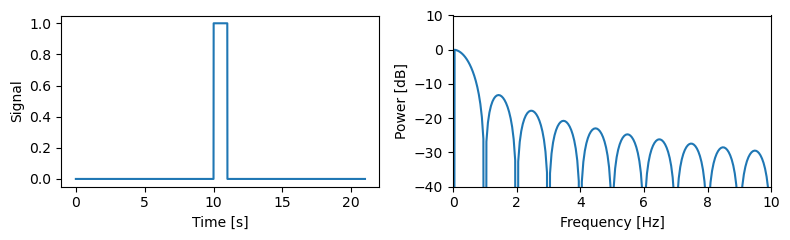

In [78]:
# Decide how many seconds of padding to use.
# Run this code block with 1, 2, and 10 seconds of 
# padding. What do you notice?

padding = 10

# Create the taper signal
sample_rate = int(1/dt)          # Define the sampling rate.
a = zeros(sample_rate * padding) # Create an interval of zeros,
b = ones( sample_rate)           # ... and 1 s of ones,
taper = hstack((a,b,a))          # ... stack them together,
t = arange(len(taper)) / sample_rate  # ... define a time axis,            

# Since we have used much of this code before,
# let's make a function out of it. This way we
# can easily reuse it without copying and pasting.

def show_spectrum(x, Fs, x_lim=[0, 10], y_lim=[-40, 10], display=True):
    dt = 1 / Fs                   # Define the time step
    T = len(x) * dt               # Define the total time
    X = rfft(x - x.mean())        # Compute the Fourier transform
    Sxx = real((X * conj(X)))     # ... and the spectrum
    Sxx = Sxx / Sxx.max()         # ... and scale it to have maximum of 0.
    
    df = 1 / T                    # Define the frequency resolution,
    faxis = arange(len(Sxx)) * df # ... to create frequency axis
    
    if display:                   # If you'd like to display the results,
        subplot(1,2,1)
        plot(arange(0, T, dt), x) # ... then plot the signal,
        xlabel('Time [s]')        # ... with axes labeled.
        ylabel('Signal')
        subplot(1,2,2)            # ... and its spectrum
        Sxx[Sxx == 0] = nan       # ... avoid division by 0 errors
        plot(faxis,10.*log10(Sxx))# Plot the spectrum vs frequency,
        xlim(x_lim)               # ... in select range,
        ylim(y_lim)
        xlabel('Frequency [Hz]')  # ... with axes labeled.
        ylabel('Power [dB]')
        tight_layout()
        show()

    return Sxx, faxis
    
show_spectrum(taper, sample_rate);# Show the taper and its spectrum
                                  # ... (suppress output with ';')

This procedure of appending zeros to a time series is called **zero padding**. It can be useful for visualizing a spectrum. But we must be careful to remember the following important fact.

<div class="alert alert-block alert-success">
The frequency resolution of the spectrum is fixed by the amount of data recorded. The number of points along the frequency axis in the spectrum is adjustable and can be increased by zero padding.
</div>

With this understanding of the impact of the rectangular taper and zero padding, let’s now return to the [spectrum of the 1 s of sinusoidal activity](#fig:4-4b) <span class="fig"><sup>fig</sup><img src="imgs/4-4b.png"></span>. We now expect that because we observe the infinite sinusoid for only a short duration (1 s), the spectral power at 10 Hz will leak into neighboring frequency bands. And, as plotted in the spectrum above, that’s indeed what we find - the side lobe structure is clearly visible. Also note that, in this example, we computed the spectrum with zero padding to evaluate the spectrum at many points along the frequency axis.

To explore further the impact of this zero padding, let’s now consider an example in Python. We define a 10 Hz sinusoid with duration 1 s, apply 10 s of zero padding and examine the impact on the spectrum:

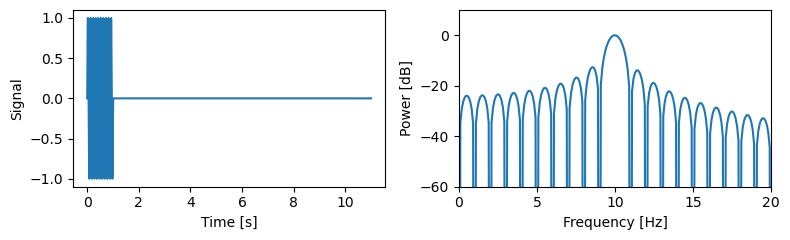

In [87]:
Fs = 500                                    # Define sampling frequency.
d = sin(2. * pi * arange(0, 1, 1/Fs) * 10)  # Make a 10 Hz sinusoid,
d = hstack((d, zeros(10 * Fs)))             # ... with 10 s of zero padding.

# Use the function we created earlier to view the spectrum. 
show_spectrum(d, Fs, x_lim=[0, 20], y_lim=[-60, 10]);

In the first three lines of this code, we define the sampling frequency (`Fs`), and the 10 Hz sine function with zero padding. Next, we use the function that we created previously to compute and plot the spectrum. Notice that we plot the spectrum on a decibel scale, and focus on the frequency interval 0–20 Hz.

<div class="question">
        
**Q.** In the `show_spectrum()` function, we subtract the mean of a signal before computing the Fourier transform. In this case it is not necessary to do this. Why?  
    
**A.** It is not necessary to subtract the mean here because the mean of the signal `d` is zero, so subtracting the mean does not impact the results.

</div>

<div class="question">
        
**Q.** How much zero padding do we add? How does this change the spacing on the frequency axis?  
    
**A.** We append `10*Fs` zeros to the end of the simulated sinusoidal data. This corresponds to 10 s (or 5,000 points). The original spacing on the frequency axis for the data was $1/T = 1 / 1$ s $= 1$ Hz. After zero-padding, the spacing on the frequency axis becomes $1 / (1 + 10\mbox{s}) = 1/(11\mbox{s}) \approx 0.091$ Hz.

</div>

The results for this case (using 10 s of zero padding) show a dominant peak at 10 Hz, as expected, and large side lobes that extend throughout the 0&mdash;20 Hz frequency range. Choices of smaller-duration zero padding and longer duration zero padding produce similar results. With 5 s of zero-padding, the plotted spectrum appears less smooth; in this case, we evaluate the spectrum at fewer points on the frequency axis, and the side lobe peaks become more jagged. The choice of 100 s of zero padding does not produce a qualitative change compared to the 10 s of zero padding; in this case, evaluating the spectrum at 10 times as many points along the frequency axis in not particularly useful.

<div class="question">
        
**Q.** Can you adjust the code above to verify these claims?

</div>

You can also see the impact of no zero padding. To do so, simply omit the third line of the Python code above. The spectrum is quite different from the original example. Without zero padding, the falloff from the 10 Hz peak appears rather smooth and gradual, and does not exhibit obvious side lobe structure, as expected after the discussion of the rectangular taper. Leakage from the 10 Hz peak into neighboring frequency bands still occurs, but without zero padding we're sampling the frequency axis too coarsely to accurately make out the side lobes.

#### Zero padding and frequency resolution: an example.
We stated in the previous section that zero padding does not improve the frequency resolution of the spectrum. As an example of this, consider a simple signal of duration 1 s that consists of two sinusoids: a 10 Hz sinusoid and a 10.5 Hz sinusoid.

<div class="question">
   
**Q.** Given this 1 s time series, can we distinguish the two rhythms in the spectrum?

**A.** No. The frequency resolution is $df = 1 / T = 1/(1\mbox{s}) = 1$ Hz. Because the two sinusoids are separated by less than 1 Hz, we cannot distinguish these two rhythms.

</div>

But, perhaps by zero padding the data, we can distinguish these two rhythms. After all, zero padding acts to increase $T$, right? We're appending lots of zeros to the time series, so the data become longer. Let's create these synthetic data in Python and investigate.

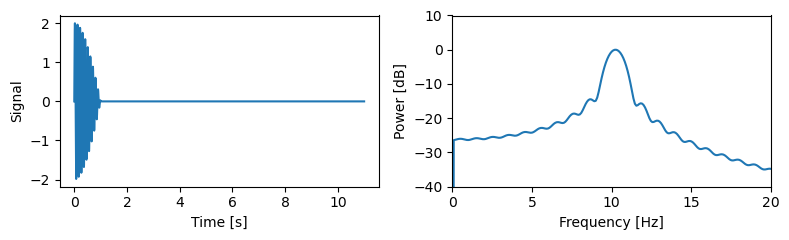

In [90]:
Fs = 500                                       # Define sampling frequency
d1 = sin(2. * pi * arange(0, 1, 1/Fs) * 10)    # Make a 10 Hz sinusoid.
d2 = sin(2. * pi * arange(0, 1, 1/Fs) * 10.5)  # Make a 10.5 Hz sinusoid.
d = d1 + d2                                    # Make the summed signal,
d = hstack((d, zeros(10 * Fs)))                # ... with 10 s of zero padding.

show_spectrum(d, Fs, x_lim=[0, 20], y_lim=[-40, 10]); # ... and compute the spectrum.

In the code above we first define the sampling frequency and then create the two sinusoids (`d1` and `d2`), sum these sinusoids to create a composite signal (`d`), and zero-pad this composite signal with 10 s of zeros. Finally, we compute and plot the spectrum as before.

<div class="question">

**Q.** Consider the spectrum above. Can you identify the two rhythms present in the simulated time series? If you change the duration of zero padding does this help reveal the two separate rhythms?

**A.** No. No choice of zero padding resolves the two spectral peaks. In  this case, the two rhythms are separated by less than the frequency resolution $df$. Zero padding the data (even with 100 s of zeros) does not resolve the two peaks. We only simulated 1 s of data, and therefore set $df = 1$ Hz; zero padding does not change this fact. 

</div>

<a id='hann-taper'></a>
## Beyond the Rectangular Taper&mdash;The Hanning Taper

We have considered so far a single type of taper (the default, a rectangular taper) and its impact on the spectrum. In particular, we noted the “smearing” of spectral peaks (i.e., side lobes) that impact neighboring frequency bands. At best these side lobes are distracting, and at worst they may contaminate our conclusions. For example, consider the spectrum for the 1 s of ECoG data.<span class="sup">fig<img src="imgs/4-2b.png"></span> Is the small peak near 10 Hz representative of a true rhythm in these data, or is it a side lobe of the large peak near 6 Hz? Many different taper shapes have been developed with the goal of reducing the side lobes that contaminate the signals. Here we consider one of these tapers, the *Hanning taper*.

The problem with the rectangular taper is its sharp edges (i.e., the rapid transitions from 0 to 1, and from 1 back to 0). To represent these sharp edges in the frequency domain requires many sinusoids, oscillating at different frequencies,<span class="sup">fig<img src="imgs/4-6.png"></span> which manifest as side lobes in the spectrum. The Hanning taper acts to smooth the sharp edges of the rectangular taper. To see this, let's plot both the Hanning taper and the rectangular taper.

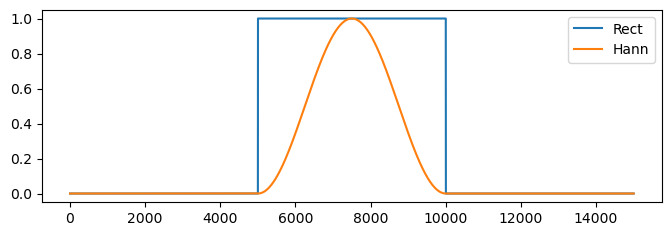

In [91]:
padding       = zeros(5000)                                     # Create 5000 pts of zeros for padding.
hanning_taper = hstack((padding, hanning(5000), padding))       # Create Hanning taper with padding.
rect_taper    = hstack((padding, ones_like(padding), padding))  # Create rectangular taper with padding.
plot(rect_taper, label='Rect')                                  # Plot the two tapers.
plot(hanning_taper, label='Hann')
legend()
show()

Notice that the Hanning taper gradually increases from zero, reaches a maximum of 1 at the center of the interval, then gradually decreases to zero. We can compare the spectra of the two tapers using the following code:

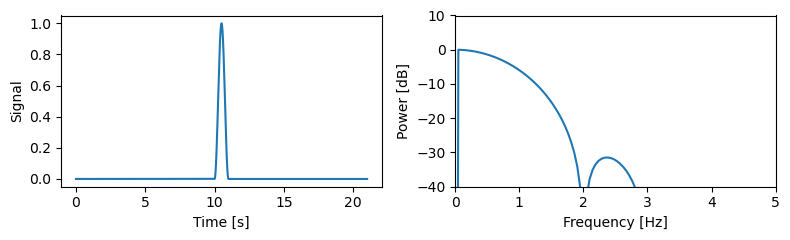

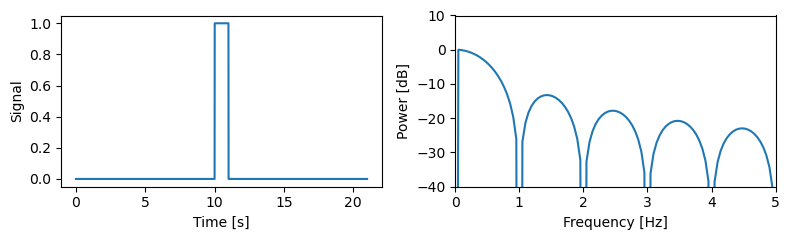

In [92]:
Fs = 500                  # Define the sampling frequency.
a  = zeros((Fs * 10))     # Create 10 seconds of zeropadding.

show_spectrum(hstack((a, hanning(Fs), a)), Fs, x_lim=[0, 5]);  # Compute spectrum of Hanning taper.
show_spectrum(hstack((a, ones(Fs), a)), Fs, x_lim=[0, 5]);     # Compute spectrum of rectangular taper.

These spectra reveal two main differences between these tapers:
1. The central lobe of the Hanning taper is wider than the rectangular taper, and
2. The side lobes in the Hanning taper are reduced compared to the rectangular taper.

These two features illustrate the trade-off between the two window choices. By accepting a wider central peak in the Hanning taper, we acquire side lobes with lower power.

The Hanning taper is applied to time series data in the same way as the rectangular taper. The data are multiplied element by element by the taper. Let’s begin by applying the Hanning taper to the ECoG data:

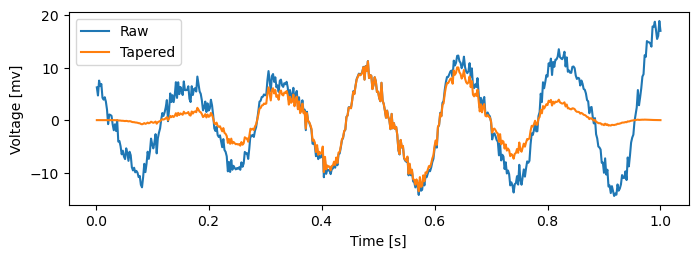

In [97]:
data = sio.loadmat('matfiles/04_ECoG-1.mat')  # Load the ECoG data,
x = data['ECoG'].reshape(-1)         # ... get the voltage trace,
t = data['t'].reshape(-1)            # ... and the time axis,
plot(t, x, label="Raw")              # ... and plot it.
xH = hanning(len(x)) * x             # Apply the Hanning taper,
plot(t, xH, label='Tapered')         # ... and plot it,
xlabel('Time [s]')                   # ... with axes labeled.
ylabel('Voltage [mv]')
legend()
show()

The NumPy function `hanning()` returns the Hanning taper, which we multiply element by element with the ECoG data in variable `x`. Notice that the slow increase in the Hanning taper reduces the amplitude of the ECoG activity near the taper edges and emphasizes the ECoG activity in the center of the interval.

<div class="question">

**Q.** Under what conditions would reducing the activity near the taper edges be a bad idea? 

*Hint:* What if the signal features of interest occur at the very beginning or very end of the observed data?

</div>

Now, let's compute the spectrum of the ECoG data with, and without, the Hanning taper.

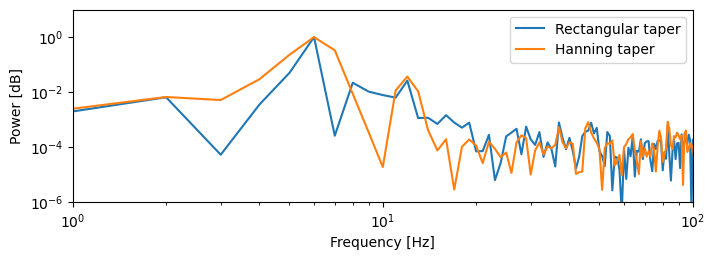

In [99]:
Fs = 1 / (t[1] - t[0])                            # Determine the sampling frequency
X, _      = show_spectrum(x, Fs, x_lim=[0, 100],  # Compute the rectangular tapered spectrum.
                     display=False);       
XH, faxis = show_spectrum(xH, Fs, x_lim=[0, 100], # Compute the Hannning tapered spectrum.
                          display=False)  
loglog(faxis, X, label='Rectangular taper')       # Plot the two spectra,
loglog(faxis, XH, label='Hanning taper')
legend()
xlabel('Frequency [Hz]')                          # ... with axes labeled.
ylabel('Power [dB]')
ylim([1e-6, 10])
xlim([1, 100])
# savefig('imgs/4-11d')
show()

<div class="question">

**Q.** The spectra for the Hanning tapered ECoG data and the rectangular tapered ECoG data are plotted above. What conclusions do you now draw regarding the rhythms present in the ECoG data? Consider, in particular, the activity near 10&mdash;15 Hz. 

**A.** The spectrum of the Hanning tapered ECoG data reveals a peak at 10&mdash;15 Hz. This peak was hidden by the side lobes of the 6 Hz peak in the (default) rectangular tapered ECoG data. The Hanning taper reduces the side lobes of the 6 Hz peak, and allows us to uncover the smaller 10&mdash;15 Hz peak that was originally obscured by these side lobes. This observation dramatically changes our interpretation of the ECoG data. We now propose that the ECoG activity consists of two rhythms: a rhythm near 6 Hz, and a second band of rhythms near 10&mdash;15 Hz. Without application of the Hanning taper, we might have missed the second rhythm by attributing it to side lobes of the 6 Hz peak.

</div>

<a id='multitaper'></a>
## Beyond the Hanning Taper&mdash;The Multitaper Method
The Hanning taper provides a nice alternative to the rectangular taper. If we’re willing to allow slightly broader spectral peaks in the frequency domain, and lose some data near the taper edges in the time domain, then the Hanning taper helps reduce the impact of side lobes. We now consider a brief introduction to a more advanced approach to tapering, the <a href="https://en.wikipedia.org/wiki/Multitaper" rel="external">multitaper method</a>. The idea of the multitaper method is to apply multiple tapers to the data, each with a different shape. The spectrum is then computed for each taper, and the results averaged over the tapers. Each taper, which is given by portions of the discrete prolate spheroidal sequences, provides an independent estimate of the (theoretical) spectrum. Therefore, the variance of the average estimate over the tapers is $1/K$ times the variance of the estimated spectrum from a single taper, where $K$ is the number of tapers used. The multitaper method has a number of additional advantages, such as minimizing the bias due to other spectral peaks outside of the frequency band being considered. We do not discuss these properties in detail, but more information can be found in [<a href="https://doi.org/10.1017/CBO9780511622762" rel="external">Percival & Walden, 1998</a>, <a href="https://buprimo.hosted.exlibrisgroup.com/primo-explore/fulldisplay?docid=ALMA_BOSU121668583370001161&context=L&vid=BU&search_scope=default_scope&tab=default_tab&lang=en_US" rel="external">Priestley, 1981</a>].
In the preceding examples, we estimated the spectrum from an observed time series. Often from these estimates we have difficulty identifying features that are significant (or not). For example, consider the small peak at 40–50 Hz in the plot of the ECoG spectrum.<a href="#fig:4-11d" class="sup">fig<img src="imgs/4-11d.png"></a> Is that peak significant or a random fluctuation we expect in an estimate from real-world ECoG data? To address this question, we might consider collecting more data and using these additional data to improve our estimate of power. However, collecting more data does not automatically improve the spectral estimate. Instead, collecting more data (i.e., increasing the duration of data recorded, $T$) produces more spectral estimates at additional frequencies, yet the spectrum at each frequency remains just as variable. We would like a way to improve the spectral estimate—a way to reduce the variability of the estimate—so that we could more confidently identify interesting features. The multitaper method offers a procedure to do so. However, this comes at a cost. If we desire reduced variance in the spectral estimate, we must accept worse frequency resolution. Let’s explore these issues in more detail.

To get a sense for the multitaper method, let’s examine some of the tapers. We will use the <a href="http://nipy.org/nitime/" rel="external">Nitime</a> module for this.

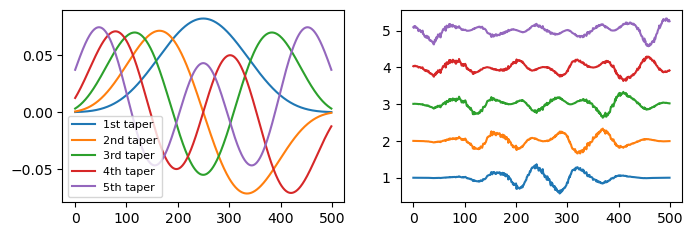

In [109]:
w, _ = spectrum.dpss_windows(N, 3, 5)  # Get the first 5 tapers,
subplot(1, 2, 1)                       # ... and plot them.
plot(w.T)
legend(['1st taper','2nd taper','3rd taper','4th taper', '5th taper'], fontsize=8)
filtered_x = array([taper * x + 2.5*i for taper,i in zip(w, range(5))])
subplot(1,2,2)
plot(filtered_x.T)
yticks(arange(0, 2.5 * 5, 2.5), [str(i+1) for i in range(5)])
show()

The first taper looks familiar—it’s similar to the Hanning taper. Notice that the first taper starts at zero, increases throughout the interval, and then decreases back to zero. As we add more tapers, each contains more “wiggles.” In particular, as the number of tapers increases, the edges of the data become better represented. Unlike the Hanning taper, which slowly approaches zero at the taper edges, some of these tapers increase near the window edges (see taper 5). This can be useful, especially if we are interested in the spectral features near the beginning and end of the data. Just as with the Hanning taper, we multiply the time series data by each taper, which emphasizes different intervals of the data. We show examples of this multiplication for the ECoG data in the plot on the right. The first taper emphasizes the middle of the ECoG data, and the fifth taper emphasizes the beginning and end of the ECoG data.

We only show the first five tapers. There are an infinite number more. How do we choose the number of tapers to use in the multitaper method? To answer this, we utilize the equation

$$
  TW = X,
$$

where $T$ is the duration of the recording, $2W$ is the desired frequency resolution (or resolution bandwidth), and we're free to choose $X$, the aptly named *time-bandwidth product*. For concreteness, let's consider the 1 s of ECoG data.

<div class="question">

**Q.** Given 1 s of data, what is the frequency resolution?

**A.** Using the equation for the frequency resolution $df = 1/T$, we find $df = 1/(1\mbox{s}) = 1$ Hz. Without applying the multitaper method, we begin with a frequency resolution of 1 Hz. We now concede some frequency resolution to apply the multitaper method and reduce the variability in the spectral estimate.

</div>

Remember that a frequency resolution of 1 Hz indicates that we can resolve features in the spectrum separated in frequency by 1 Hz or more. For example, at a frequency resolution of 1 Hz, we can distinguish 10 Hz activity from 9 Hz or 11 Hz activity. However, we are unable to distinguish 10 Hz activity from 10.5 Hz or 9.5 Hz; those frequencies lie within the frequency resolution.

Let’s assume we do not require a frequency resolution of 1 Hz; instead, we are satisfied with a frequency resolution of 6 Hz. Using the multitaper method, we trade off a worse frequency resolution to improve the estimate of the spectrum. In this case, $T = 1$ s, and we are willing to accept a resolution bandwidth of $2 W = 6$ Hz. So, from the equation above, we compute the time-bandwidth product and find $T W = 3$. Now, with this value, we select the number of tapers following this rule of thumb:

$$
  \mbox{No. of tapers} = 2TW - 1.
$$

We choose the first $2 T W - 1$ tapers because doing so allows us to preserve most of the information present in the original data. We could choose fewer tapers, but in most cases we follow this rule of thumb and pick as many tapers as we can. Choosing more tapers does not improve the multitaper estimate of the spectrum and may lead to spurious results; for more details, see [<a href="https://doi.org/10.1017/CBO9780511622762" rel="external">Percival & Walden, 1998</a>]. So, for the ECoG data of interest here, we select the number of tapers to be $2 \times 3 - 1 = 5$. These five tapers are plotted above on the left. Applying these tapers to the ECoG data, we create the five time series shown on the right. We then compute the spectrum of each tapered ECoG time series, and average the resulting spectra across the five tapers. Through this averaging procedure across tapers, we reduce the variability of the spectral estimate.

<div class="math-note">
    
**Multitaper method tradeoff:** The multitaper method permits a trade-off between frequency resolution and variance of the spectrum. If we can tolerate worse frequency resolution, we can include more tapers and reduce the spectrum variance.

</div>

<div class="question">
    
**Q.** Given 10 s of data, we demand a frequency resolution of 2 Hz or better. Using the multitaper method, what is the maximum number of tapers we could select and still maintain the desired frequency resolution?

</div>

The multitaper method is a sophisticated approach, and we have only touched on the surface in this brief discussion. There are many detailed references and important applications [<a href="https://doi.org/10.1017/CBO9780511622762" rel="external">Percival & Walden, 1998</a>, <a href="https://buprimo.hosted.exlibrisgroup.com/primo-explore/fulldisplay?docid=ALMA_BOSU121668583370001161&context=L&vid=BU&search_scope=default_scope&tab=default_tab&lang=en_US" rel="external">Priestley, 1981</a>]. Fortunately, there are also Python software packages and functions to implement and apply the multitaper method. We will use the function `multi_taper_psd()` from the <a href="http://nipy.org/nitime/index.html" rel="external">Nitime</a> package to compute the multitaper spectrum of the ECoG data:

In [110]:
NW = 3  # Define the normalized time-bandwidth product,
        # ... and compute the multitaper spectrum.
faxis, Sxx, _ = spectrum.multi_taper_psd(x - x.mean(), Fs=1/dt, NW=NW);

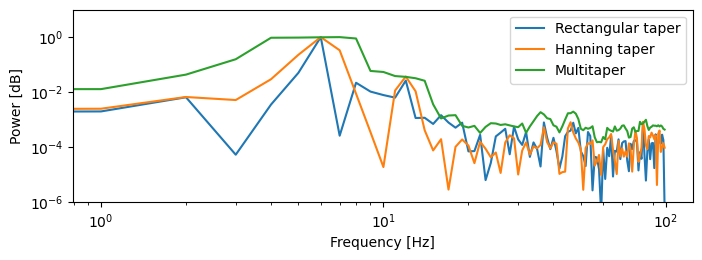

In [111]:
loglog(X[:100], label='Rectangular taper')  # Plot the spectrum,
loglog(XH[:100], label='Hanning taper')     # ... computed in three wasy
loglog(faxis[:100], Sxx[:100] / Sxx.max(), label='Multitaper')
xlabel('Frequency [Hz]')                    # ... with axes labeled.
ylabel('Power [dB]')
legend()
ylim([1e-6, 10])
show()

The function `multi_taper_psd()` takes three inputs: the data (here `x-x.mean()`), the sampling frequency (here `1/dt`), and the normalized half-bandwidth (here `NW`). The normalized half-bandwidth is equivalent to the half-bandwidth *W* if the total time is normalized to one second. By default, `multi_taper_psd()` sets the number of tapers to $2 N W - 1$. The function `multi_taper_psd()` returns the frequency points (`faxis`) and multitaper estimate of the spectrum (`Sxx`). The plot above shows the spectrum of the ECoG data computed in three ways: using the rectangular taper, the Hanning taper, and the multitaper method.

<div class="question">

**Q.** Compare the spectra of the ECoG data in the figure above. How do the multitaper method results differ from the results computed with the other tapers? Do any new features appear in the spectrum using the multitaper method? 

</div>

<div class="question">

**Q.** Because the recording time here is 1 second, the time-bandwidth product is equal to the normalized time-bandwidth product. This means that the frequency resolution is simply `2 * NW`. If instead, the recording length were 2 seconds, how would you calculate the frequency resolution from the normalized time-bandwidth, `NW`?

</div>

<a id='ci'></a>
## Confidence Intervals of the Spectrum

Another useful feature of the `pmtm()` function is the ability to compute confidence intervals for the spectrum. The confidence interval for a multitaper spectral estimator with $K$ tapers can be computed using a chi-square distribution with $2K$ degrees of freedom [<a href="https://doi.org/10.1017/CBO9780511622762" rel="external">Percival & Walden, 1998</a>], 

$$
  \frac{2K}{\chi^2_{\alpha}(2K)}\hat S(f) < S(f) < \frac{2K}{\chi^2_{1-\alpha}(2K)}\hat S(f) 
$$

Here, $\hat S(f)$ is our estimate of the spectral power at frequency $f$ (i.e., the values in `Sxx`), $S(f)$ is the true spectral power that we want to estimate, and $\chi^2_{\alpha}(2K)$ is the quantile corresponding the the probability $\alpha$ according to a chi-square distribution with $2K$ degrees of freedom. We can write this as a function to compute the confidence intervals.

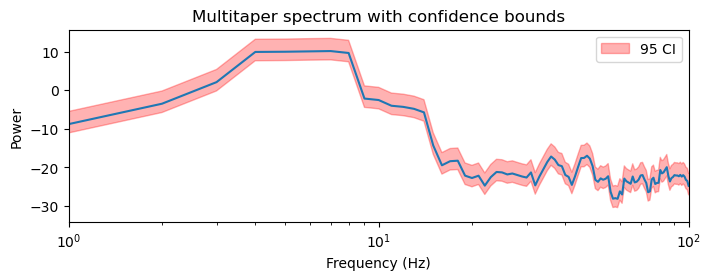

In [132]:
K = 2 * NW - 1                   # Compute the default number of tapers.
    
def chi2conf(K, Sxx=1, ci=.95):  # Define a short function to compute confidence bounds.
    '''
    Returns confidence bounds computed using chi-square 
    distribution.
    Input: 
        K (int): Number of tapers
        Sxx (array): Multitaper spectrum (optional)
        ci ([0.5, 1]): Confidence level (optional)
    Output:
        lb, ub: lower and upper bounds
    '''
    ub = 2 * K / chi2.ppf(1 - ci, 2 * K) * Sxx
    lb = 2 * K / chi2.ppf(    ci, 2 * K) * Sxx
    return lb, ub

def dB(x):                       # For convenience, define a function to convert
    '''Convert to decibels'''    # ... a signal to decibels
    return 10 * log10(x)

NW = 3
faxis, Sxx, _ = spectrum.multi_taper_psd(x - x.mean(), Fs=1/dt, NW=NW);
lb, ub = chi2conf(K, Sxx, ci=0.95)        # Use the function to get confidence bounds

fill_between(faxis, dB(lb), dB(ub),  # Plot results
                 color=[1,0,0], alpha=.3, label="95 CI")
semilogx(faxis[1:],dB(Sxx[1:]))
legend()
xlabel('Frequency (Hz)')
ylabel('Power')
title('Multitaper spectrum with confidence bounds')
xlim([faxis[1], 100])
show()

<div class="question">

**Q.** Compute and plot the multitaper spectra for different choices of time-bandwidth product. For example, use $TW = 3,\ 5,\ 8,\ 10$. For each case determine the frequency resolution, and compare your answer to the resulting plots. How does changing the time-bandwidth product impact the plotted spectra? 

</div>

<div class="question">

**Q.** Use the spectral analysis results to draw some conclusions about the data. What rhythms do you think are present?

**A.** Our previous analysis using the Hanning taper suggested two peaks in the spectrum: a large peak near 6 Hz, and a second smaller peak near 10–15 Hz. Both peaks are still visible, at least partially, in the multitaper spectra estimates. We notice that as the time-bandwidth product increases, the frequency resolution becomes worse, and it becomes more difficult to resolve these two peaks; these neighboring peaks start to smear together. This is expected and the trade-off we accept in the multitaper method. The big payoff of the multitaper method occurs in the higher-frequency bands. As the time-bandwidth product increases, we observe a small elevation across a broad frequency range, at approximately 30–50 Hz. The spectral density in this interval is small and was hidden by the noise in the previous spectral estimates using the rectangular taper or the Hanning taper. However, by using many tapers in the multitaper method, we reduce this noise and reveal the broad elevation of power. Physiologically, the impact of this observation is enormous; the data exhibit a broad gamma band peak—one of the best studied and understood frequency bands in the brain—with implications for cognitive function and dysfunction [<a href="https://doi.org/10.1093/acprof:oso/9780195301069.001.0001" rel="external">Buzsáki, 2006</a>].

</div>

<a id='summary'></a>

### Summary

In this notebook, we analyzed the rhythmic activity present in 1 s of ECoG data. We computed the spectrum and considered two issues: zero padding and tapering. We discussed that zero padding can increase the number of points along the frequency axis but cannot change the frequency resolution. We also explored the trade-off between three different tapers: the rectangular taper, the Hanning taper, and the multitaper method. The Hanning taper reduces the side lobes present in the rectangular taper, but fattens the spectral peaks. The multitaper method reduces the variance of the spectrum at the cost of worsened frequency resolution. Applying all three measures to the ECoG data allowed us to explore the rhythmic activity of these data in different ways. All three methods suggest rhythmic content at low frequencies, near 6–7 Hz, consistent with the visual inspection of the time series. Applying the Hanning taper, we uncovered activity in the 10–15 Hz range. Applying the multitaper method, we uncovered broadband activity at 30–50 Hz. This activity, hidden in the noisy spectrum, only became apparent upon increasing the number of tapers. However, this increase necessarily reduces the frequency resolution and can hide the low-frequency rhythms. In this case, we find it useful to examine the spectrum in a variety of ways.

Here we have only touched the surface of these concepts. Further discussions of zero padding, tapering, and the multitaper method may be found in 
[Percival & Walden, 1998](https://doi.org/10.1017/CBO9780511622762), 
[Priestly, 1981](https://www.elsevier.com/books/spectral-analysis-and-time-series-two-volume-set/priestley/978-0-08-057055-6), 
and <a href="http://www.cambridge.org/us/catalogue/catalogue.asp?isbn=9780521880688" rel="external">Press, Teukolsky, Vetterling & Flannery, 2007</a>.

[Return to top](#top)

<a id="donate"></a>
## Donate
If you enjoy Case-Studies-Python, and would like to share your enjoyment with us, sponsor our coffee consuption <a href="https://www.paypal.com/donate/?hosted_button_id=DL8P5ZGS9962U">here</a>.

<a id="appendix"></a> 
## Appendix: Multiplication and Convolution in Different Domains

We stated in this notebook the important fact that multiplication in the time domain is equivalent to convolution in the frequency domain. Mathematically, we may express this relation as,

$$
  FT[xw] = FT[x]\star FT[w] \, ,
  \tag{1}
$$

where $x$ and $w$ are two time series, $FT[x]$ is the Fourier transform of $x$, and $X \star Y$ indicates the convolution of $X$ and $Y$, 

$$
  X \star Y[\beta] = \int_{-\infty}^{\infty}X[b]Y[\beta - b]db.
$$

The convolution of two functions (with arguments $b$ in this formula) is itself a function of the same argument (with symbol $\beta$ in this formula). Equation (1) states that the Fourier transform of the element-by-element product of $x$ and $w$ equals the convolution of the Fourier transform of $x$ and the Fourier transform of $w$. We consider here an equivalent, alternative statement: that convolution in the time domain is equivalent to multiplication in the frequency domain. Mathematically,

$$
  FT[x \star w] = FT[x]FT[w].
$$

This equation states that the Fourier transform of the convolution of $x$ and $w$ equals the product of the Fourier transform of $x$ and the Fourier transform of $w$. To prove this relation, let’s consider the Fourier transform of the convolution of $x$ and $w$. We use the following expression for the continuous-time Fourier transform,

$$
  FT(x \star w[\tau]) = \int_{-\infty}^{\infty}\big(x\star w[\tau]\big)e^{-2 \pi i f \tau}d\tau,
$$

where the notation $[\tau]$ indicates that the convolution $(x\star w)$ is a function of time $\tau$. Now, let's substitute the definition of convolution into this expression and simiplify using an introduction of a second exponential expression,

$$
  \begin{align}
  FT(x \star w[\tau]) = & 
  \int_{-\infty}^{\infty}
  \bigg( \int_{-\infty}^\infty x[t]w[\tau-t]dt \bigg)
  e^{-2\pi i f \tau} 
  d\tau \\
  %
  = & \int_{-\infty}^{\infty} 
  \int_{-\infty}^\infty 
  x[t]w[\tau-t]dt\ 
  e^{-2\pi i f (\tau - t)} 
  e^{-2\pi i f t} 
  d\tau \\
  %
  = & \int_{-\infty}^{\infty} \int_{-\infty}^\infty 
  \big( x[t] e^{-2\pi i f t} \big)
  \big( w[\tau - t] e^{-2\pi i f (\tau - t)}\big)
  dt\ d\tau.\\
  \end{align}
$$

Setting $T \equiv \tau - t$, we find

$$
  \begin{align}
  FT(x \star w[\tau]) = & 
  \int_{-\infty}^{\infty} \int_{-\infty}^\infty 
  \big( x[t] e^{-2\pi i f t} dt \big)
  \big( w[T] e^{-2\pi i f (T)} dT \big) \\
  %
  = & \bigg( \int_{-\infty}^{\infty}x[t] e^{-2\pi i f t} dt \bigg)
  \bigg(\int_{-\infty}^{\infty} w[T] e^{-2\pi i f (T)} dT \bigg) \\
  %
  = & FT[x]FT[w]
  %
  \end{align}
$$

and therefore conclude that the Fourier transform of the convolution of $x$ and $w$ equals the element-by-element product of their Fourier transforms.

We may compute a simple example to illustrate this relation:

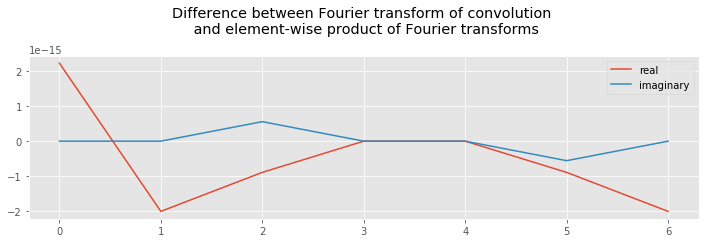

In [20]:
x = array([ 3,   4,    5, 6])            # Define a simple signal x,
w = array([-1, 0.1, -0.2, 1])            # ... and another simple signal w.
a = fft(convolve(w, x))                  # Take the Fourier transform of the convolution,
b = fft(hstack([w, [0, 0, 0]])) * \
    fft(hstack([x, [0, 0, 0]]))          # ... and the product of the Fourier transforms.
    
plot(a.real - b.real, label='real')      # Plot the difference
plot(a.imag - b.imag, label='imaginary')
legend()
title('Difference between Fourier transform of convolution \n and element-wise product of Fourier transforms\n')
show()

In the first two lines, we define two simple signals; each consists of only four elements, which is enough to illustrate the relation. In the third line, we first compute the convolution of $w$ and $x$, and then the Fourier transform. In the fourth and fifth lines, we compute the Fourier transform of each variable, and then their element-by-element product. Notice that we zero-pad both variables before computing their Fourier transforms. We do so to avoid computing circular correlations between the variables (i.e., wrapping around one variable when comparing it to another). Also, we make the lengths of variables $a$ and $b$ the same. Evaluating the statement, we find the difference between $a$ and $b$ to be on the order of $10^{-15}$, which is very close to zero.

[Return to top](#top)